# Medford Disaster Router
<br>
<b>Michael Ruggiero<br>
   Other contributors: Cengiz Imga, Dali Souayah</b>

# Index

1. [Problem Statement](#PS)
2. [Data Preparation](#Data)
    1. [Major Road Functions](#MRF)
    2. [Routing](#Route)
    3. [Disaster Radius](#Dis)
    4. [Edge Manipulation and Visualizations](#EM)
3. [Dataset Creation](#Maker)
    1. [Data Cleaning](#Clean)
    2. [Statistics](#Stats)
4. [Google Directions](#Google)
5. [Initial Monte Carlo Simulation](#M)

In [1]:
# Function imports
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

ox.config(use_cache=True, log_console=True)
ox.__version__

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Problem Statement <a id = "PS"></a>

1) Build a NLP model identifies road closures based on in social media 

2) Use Google maps to chart travel based on different times of day

3) Translate "bad traffic areas" as flaged map locations

4) Simulate a natural disaster that destroys roads 

5) Reflect the affected roads into a map in red color

6) Produce a map of valid rescue roads/escape routes

7) Optimize dispatch for police and rescue 

## 2. Data Collection/Import Medford

#### Basic information about an importated city. Due to my site specific knowledge, I decided to protoype this model on the city of Medford. Other city disasters will be investigated. I-93 was removed from the road network to simplify the initial analysis. 

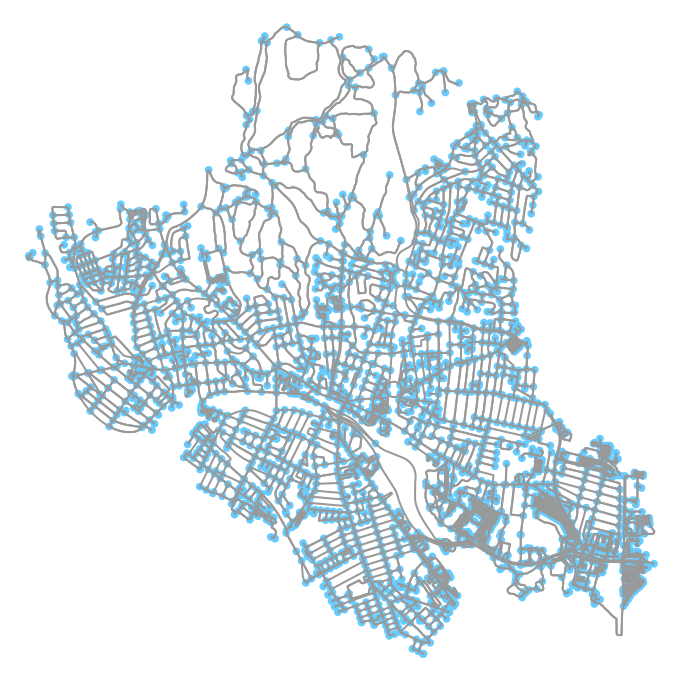

In [2]:
# get a graph for some city
place = {'city' : 'Medford',
         'state' : 'MA',
         'country' : 'USA'}


medford = ox.graph_from_place(place, network_type='bike')
fig, ax = ox.plot_graph(medford)

In [14]:
# what sized area does our network cover in square meters?
medford_proj = ox.project_graph(medford)
nodes_proj = ox.graph_to_gdfs(medford_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print(graph_area_m)

# show basic stats about the network
medford_stats = ox.basic_stats(medford_proj, 
                               area=graph_area_m, 
                               clean_intersects=True,
                               circuity_dist='euclidean')

# medford_stats = ox.extended_stats(medford_proj, ecc=True, bc=True, cc=True)

pd.DataFrame(medford_stats).set_index("streets_per_node_counts")

24864732.339954104


n     m     k_avg  intersection_count  \
streets_per_node_counts                                             
0                        3098  7856  5.071659                2662   
436                      3098  7856  5.071659                2662   
14                       3098  7856  5.071659                2662   
2230                     3098  7856  5.071659                2662   
402                      3098  7856  5.071659                2662   
16                       3098  7856  5.071659                2662   

                         streets_per_node_avg  streets_per_node_proportion  \
streets_per_node_counts                                                      
0                                    2.854099                     0.000000   
436                                  2.854099                     0.140736   
14                                   2.854099                     0.004519   
2230                                 2.854099                     0.719819   
402                                  2.854099                     0.129761   
16                                   2.854099                     0.005165   

                         edge_length_total  edge_length_avg  \
streets_per_node_counts                                       
0                               626885.772        79.797069   
436                             626885.772        79.797069   
14                              626885.772        79.797069   
2230                            626885.772        79.797069   
402                             626885.772        79.797069   
16                              626885.772        79.797069   

                         street_length_total  street_length_avg  \
streets_per_node_counts                                           
0                                  353941.26          80.790062   
436                                353941.26          80.790062   
14                                 353941.26          80.790062   
2230                               353941.26          80.790062   
402                                353941.26          80.790062   
16                                 353941.26          80.790062   

                         street_segments_count  node_density_km  \
streets_per_node_counts                                           
0                                         4381       124.594142   
436                                       4381       124.594142   
14                                        4381       124.594142   
2230                                      4381       124.594142   
402                                       4381       124.594142   
16                                        4381       124.594142   

                         intersection_density_km  edge_density_km  \
streets_per_node_counts                                             
0                                     107.059266      25211.84477   
436                                   107.059266      25211.84477   
14                                    107.059266      25211.84477   
2230                                  107.059266      25211.84477   
402                                   107.059266      25211.84477   
16                                    107.059266      25211.84477   

                         street_density_km  circuity_avg  \
streets_per_node_counts                                    
0                              14234.67002      1.077671   
436                            14234.67002      1.077671   
14                             14234.67002      1.077671   
2230                           14234.67002      1.077671   
402                            14234.67002      1.077671   
16                             14234.67002      1.077671   

                         self_loop_proportion  clean_intersection_count  \
streets_per_node_counts                                                   
0                                    0.004073                      1655   
436         

In [15]:
# Edge and Node projection
nodes_med, edges_med = ox.graph_to_gdfs(medford, nodes=True, edges=True)

In [16]:
nodes_med.head(2)

highway       osmid  ref          x          y  \
66478081    turning_circle    66478081  NaN -71.100780  42.429287   
1754021893             NaN  1754021893  NaN -71.110187  42.426412   

                                         geometry  
66478081           POINT (-71.1007798 42.4292871)  
1754021893  POINT (-71.11018660000001 42.4264119)

In [17]:
nodes_med.shape

(3098, 6)

## 2a. Major Roads Functions

#### To avoid clutting up the notebook, all major functions have been exported into the "graph_functions.py" python file. See this file for futher information.

In [18]:
#Functions built for this project
# %load graph_functions.py

import graph_functions as gf

#### The "node_roader" function returns a data dictionary of the essential information from a plotted object.

5     	 nodes in        MA 38;MA 60 	 colored 	 lightsteelblue
18    	 nodes in        MA 16;MA 38 	 colored 	 crimson
155   	 nodes in              MA 38 	 colored 	 steelblue
187   	 nodes in              MA 60 	 colored 	 mediumseagreen
65    	 nodes in              MA 16 	 colored 	 dimgrey
93    	 nodes in              MA 28 	 colored 	 sienna

major road map for region


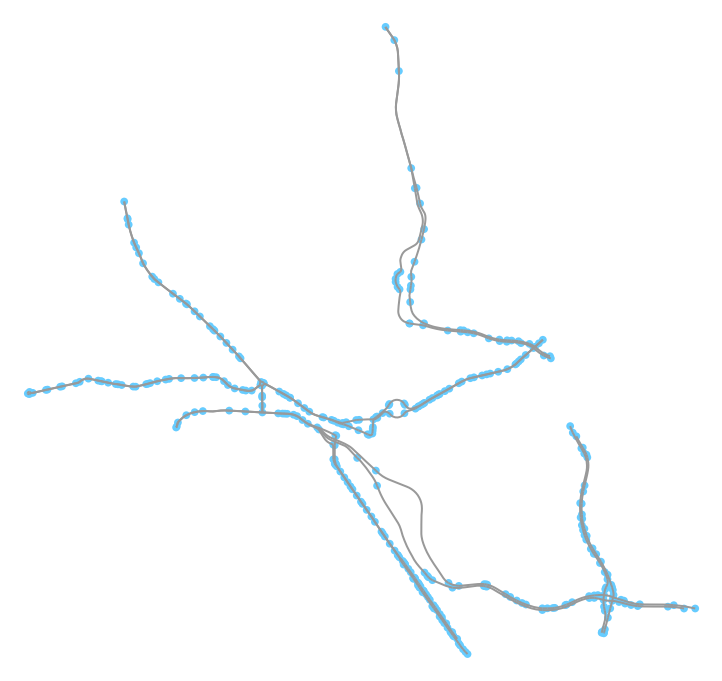

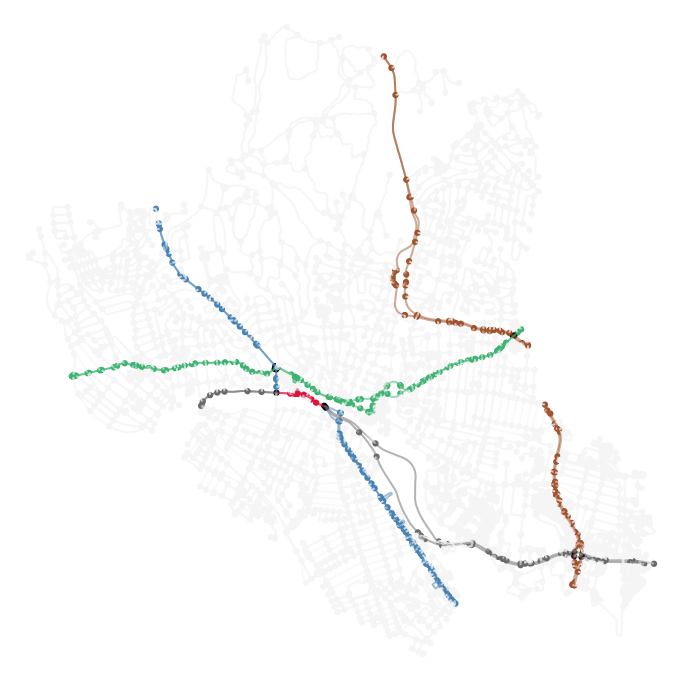

In [19]:
medford_data = gf.node_roader(medford)

In [20]:
medford_data.keys()

dict_keys(['graph', 'edges', 'nodes', 'major_roads', 'major_intersections', 'major_map', 'color_dictionary', 'edge_color', 'node_color'])

In [21]:
edges_med, nodes_med, medford = medford_data["edges"], medford_data["nodes"], medford_data["graph"]

In [22]:
nodes_med.major_inter.value_counts()

0    2725
1     351
2       9
3       6
4       4
6       3
Name: major_inter, dtype: int64

In [23]:
#Long/Lat information
nodes_med[["x","y"]].describe()

x            y
count  3098.000000  3098.000000
mean    -71.104385    42.417810
std       0.017585     0.011473
min     -71.147362    42.396193
25%     -71.116528    42.408226
50%     -71.101943    42.416830
75%     -71.091419    42.426176
max     -71.073105    42.451141

In [25]:
nodes_med.head(2)

highway       osmid  ref          x          y  \
66478081    turning_circle    66478081  NaN -71.100780  42.429287   
1754021893             NaN  1754021893  NaN -71.110187  42.426412   

                                         geometry  major       color  \
66478081           POINT (-71.1007798 42.4292871)  minor  whitesmoke   
1754021893  POINT (-71.11018660000001 42.4264119)  minor  whitesmoke   

            major_inter  
66478081              0  
1754021893            0

## 2b. Routing

#### The "random point" and "get_nearest_node" functions are designed to pair any longitude and latitude location with a node on the road network. Routing is handled bu the Networkx package. 

In [26]:
#A function to generate a random lat/long point
gf.random_point()

(-4.564236287744961, -83.12728159778895)

In [27]:
random_point_A = gf.random_point()
random_point_B = gf.random_point()

# get the nearest network node to each random point
orig_node = ox.get_nearest_node(medford, random_point_A)
dest_node = ox.get_nearest_node(medford, random_point_B)

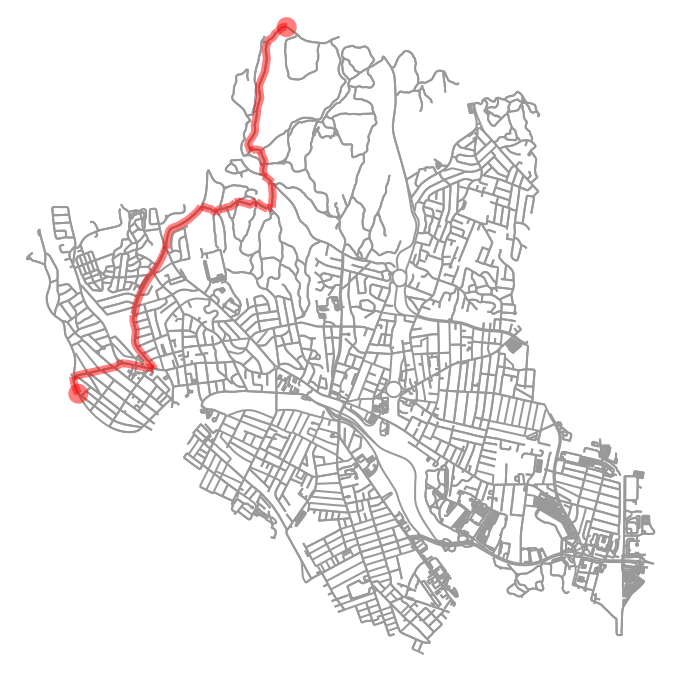

In [28]:
# find the route between these nodes then plot it
route = nx.shortest_path(medford, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(medford, route, node_size=0)

In [29]:
# Length of route in meters
nx.shortest_path_length(medford, orig_node, dest_node, weight='length')

5718.696999999998

In [30]:
# Absolute Distance between two nodes (as the crow flies)
ox.great_circle_vec(medford.node[orig_node]['y'], medford.node[orig_node]['x'],
                    medford.node[dest_node]['y'], medford.node[dest_node]['x'])

4109.394864817133

## 2c. Disaster Radius

#### "Disaster_generator" creates a graph object around a node given a radius. This subgraph serves as the region effected by the disaster. 

In [31]:
d_location = nodes_med[["y","x"]].sample(1).values[0]

In [33]:
print(d_location)

[ 42.4306193 -71.1129258]


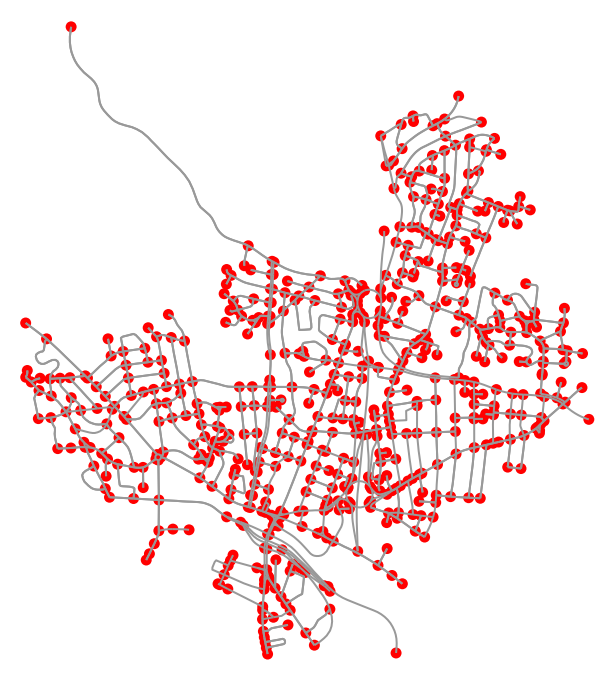

In [32]:
#returns a graphs object of a disater
disaster = gf.disaster_generator(nodes_med, location_point = d_location, radius = 2500)

In [34]:
nodes_dis, edges_dis = ox.graph_to_gdfs(disaster)

#### The disaster is then reimposed onto the original city graph.

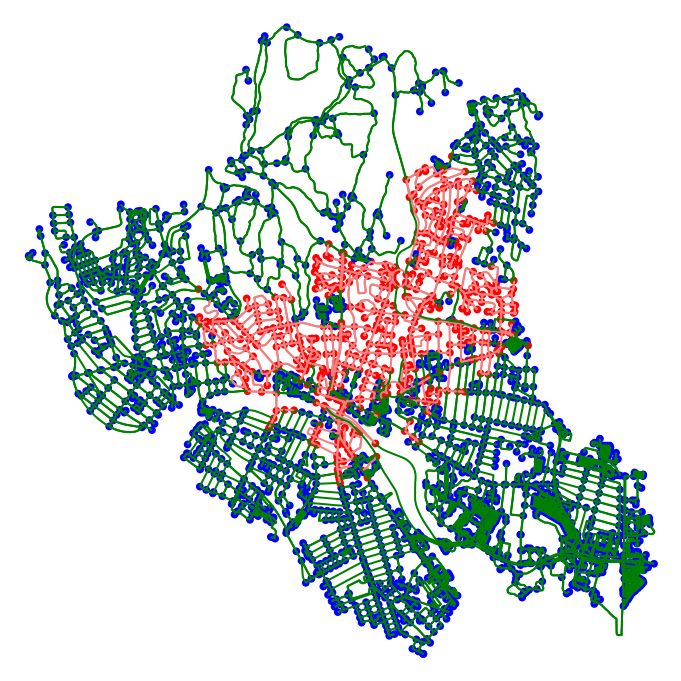

(<Figure size 585.286x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125a8d9e8>)

In [35]:
#Set Colors
ec = ['lightcoral' if i in disaster.edges() else 'green' for i in medford.edges()]
nc = ['red' if i in disaster.nodes() else 'blue' for i in medford.nodes()]

#Plot energency grid
ox.plot_graph(medford, node_size=15, node_color = nc ,edge_color=ec)

In [36]:
nx.degree_histogram(disaster)

[0, 8, 100, 68, 92, 39, 265, 10, 26, 1]

#### The "road_kill" function destroys a given percentage of roads inside the disaster zone. These destroyed roads are removed from edges of the city network. Comparing the images above and below will demonstrate that some nodes are now completely isolated  as all connecting roads are destroyed.

138320 roads remain of 149264 total roads


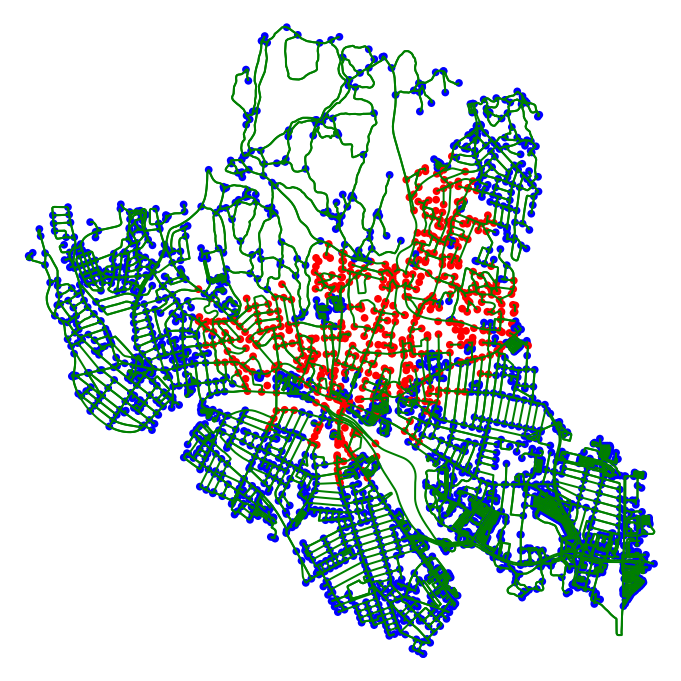

In [41]:
medford_disaster = gf.road_kill(disaster,
                                nodes_med,
                                edges_med,
                                kill_percentage = .8 )

## 2d. City Visualizations

#### Various city road information and city information

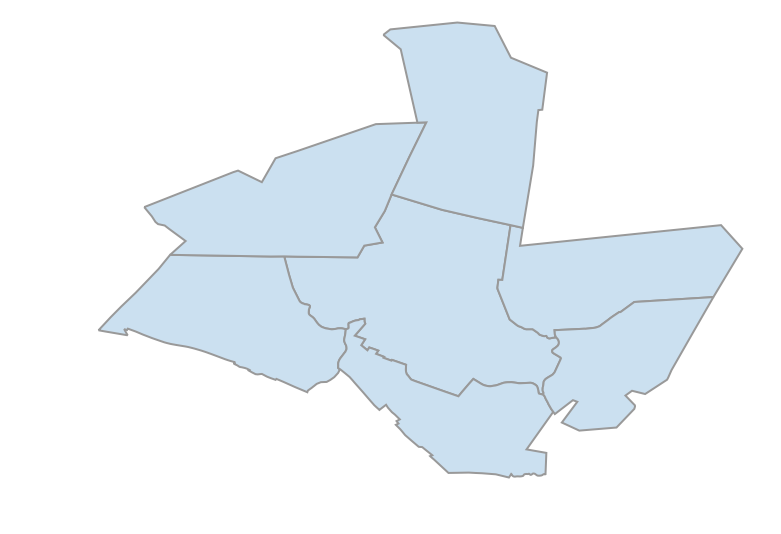

In [ ]:
# get the boundary polygons for neighboring cities, save as shapefile, project to UTM, and plot
place_names = ['Medford, MA, USA', 
               'Arlington, MA, USA',
               'Somerville, MA, USA',
               'Malden, MA, USA',
#                'Melrose, MA, USA',
               'Winchester, MA, USA',
               'Stoneham, MA, USA',
               'Everett, MA, USA',
              ]
medford_area = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(medford_area)

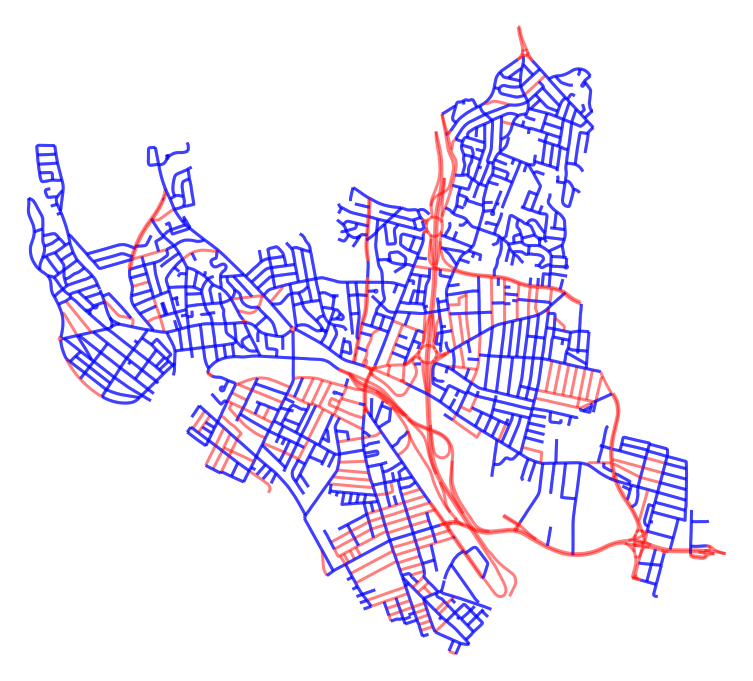

In [ ]:
# highlight one-way roads
oneway = ox.graph_from_place(place, network_type='drive')
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in oneway.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(oneway, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

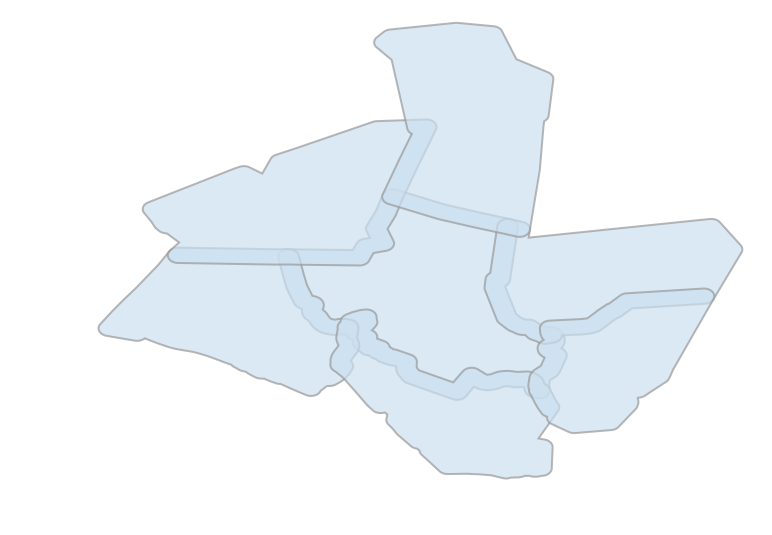

In [ ]:
#Neighboor hoods buffered
neigboors_buffered = ox.gdf_from_places(place_names, gdf_name='neighboors', buffer_dist=250)
fig, ax = ox.plot_shape(neigboors_buffered, alpha=0.7)

## 3. Data Creation

#### "Random_zone_picker" creates random crosstown traffic .CSVs for google to analyze. 

In [42]:
# DF builder of start/end nodes with long/lat and times 
# Already done, commenting out to avoid clutter in notebook

router = gf.random_zone_picker(nodes_med, 10)
#router.to_csv("more_zones.csv")

0


In [44]:
router.head(3)

osmid_start    x_start    y_start  start_zone  osmid_end      x_end  \
0     66472630 -71.116727  42.407028           0   66437756 -71.091194   
1     66472630 -71.116727  42.407028           0   66437756 -71.091194   
2     66472630 -71.116727  42.407028           0   66437756 -71.091194   

       y_end  end_zone   Time  
0  42.426873         1   8:30  
1  42.426873         1  15:30  
2  42.426873         1  17:30

#### Police are not restricted to one city, thus, a region around Medford is mapped to potentially use as routes around the disaster. Here a 5.5 km radius is plotted around city hall. 

In [45]:
# network from address, including only nodes within 5.5km along the network from city hall
neighbor = ox.graph_from_address(address='85 George P. Hassett Drive,\
                                    Medford, MA 02155',
                                    distance=5500,
                                    distance_type='network',
                                    network_type='walk')

# you can project the network to UTM (zone calculated automatically)
neighbor_projected = ox.project_graph(neighbor)

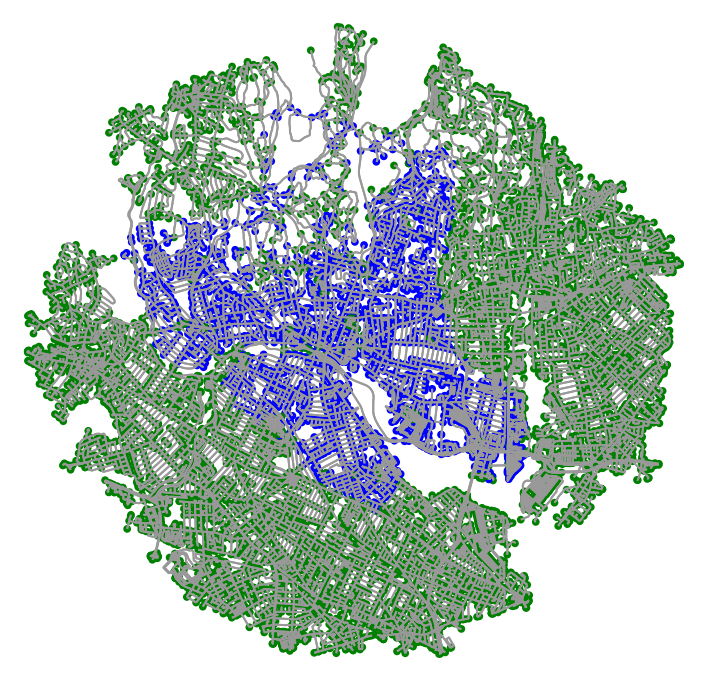

In [46]:
# Edge and Node projection
nodes_area, edges_area = ox.graph_to_gdfs(neighbor_projected,
                                        nodes=True,
                                        edges=True)

nc = ['blue' if i in medford.nodes() else 'green' for i in neighbor.nodes()]

ox.plot_graph(neighbor,
              node_size=15,
              node_color = nc);

166   	 nodes in         US 3;MA 2A 	 colored 	 cadetblue
10    	 nodes in        MA 38;MA 60 	 colored 	 darkslateblue
24    	 nodes in        MA 16;MA 38 	 colored 	 darkolivegreen
330   	 nodes in              MA 38 	 colored 	 yellowgreen
28    	 nodes in               MA 2 	 colored 	 mediumpurple
582   	 nodes in              MA 60 	 colored 	 mediumturquoise
270   	 nodes in              MA 16 	 colored 	 darkseagreen
150   	 nodes in              MA 99 	 colored 	 darkslateblue
42    	 nodes in               US 3 	 colored 	 indianred
18    	 nodes in   US 3;MA 2A;MA 60 	 colored 	 darkslateblue
30    	 nodes in    US 3;MA 2;MA 16 	 colored 	 darkkhaki
22    	 nodes in         US 3;MA 16 	 colored 	 lightslategrey
308   	 nodes in              MA 2A 	 colored 	 indianred
348   	 nodes in              MA 28 	 colored 	 grey

major road map for region


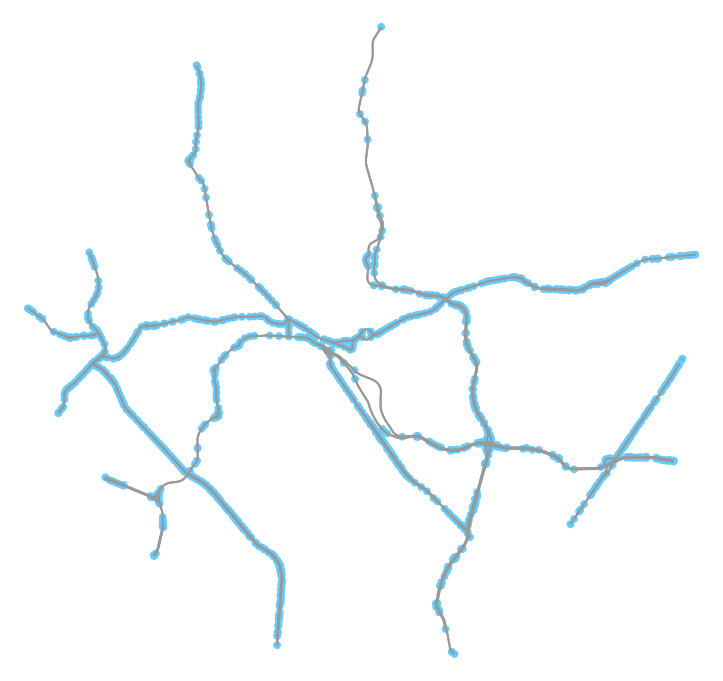

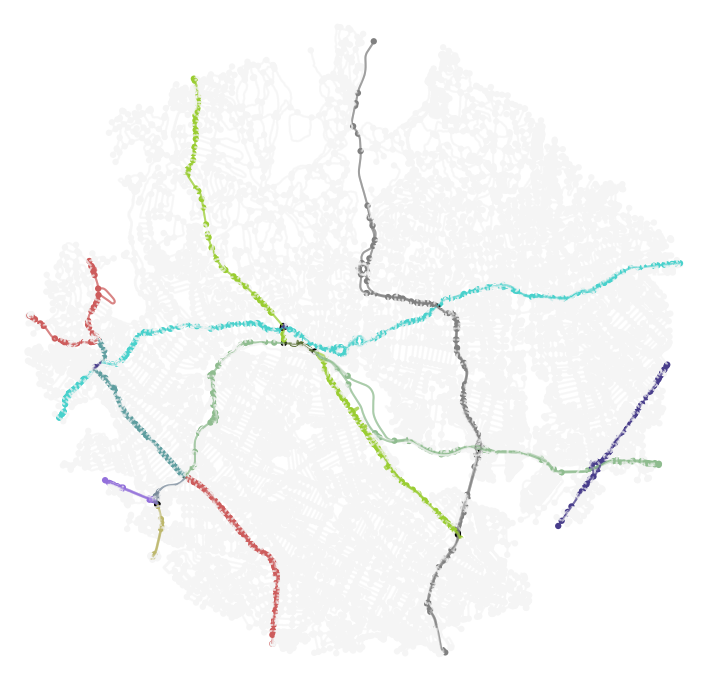

In [47]:
neighbor_data = gf.node_roader(neighbor)

#### In the above coloration, black nodes serve as significant intersection between major roads. 

In [50]:
black = neighbor_data["nodes"]
black[black.color == "black"].head(2)

highway     osmid          ref          x          y  \
66455370  traffic_signals  66455370  MA 16/MA 38 -71.117942  42.419096   
66464342  traffic_signals  66464342          NaN -71.089860  42.424022   

                                geometry                    major  color  \
66455370    POINT (-71.117942 42.419096)  MA 16;MA 38 MA 38 MA 16  black   
66464342  POINT (-71.0898596 42.4240215)              MA 60 MA 28  black   

          major_inter  
66455370            6  
66464342            3

In [51]:
neighbor_data.keys()

dict_keys(['graph', 'edges', 'nodes', 'major_roads', 'major_intersections', 'major_map', 'color_dictionary', 'edge_color', 'node_color'])

In [52]:
nodes_area, edges_area, neighborhood = neighbor_data["nodes"], neighbor_data["edges"], neighbor_data["graph"]

#### Major node connection vector

In [54]:
for i in neighbor_data['major_intersections']:
    print("Number of major nodes: ",
          len(neighbor_data['major_intersections'][i]), 
         "\t with degree ",
          i,)

Number of major nodes:  0 	 with degree  0
Number of major nodes:  0 	 with degree  1
Number of major nodes:  19 	 with degree  2
Number of major nodes:  0 	 with degree  3
Number of major nodes:  1053 	 with degree  4
Number of major nodes:  0 	 with degree  5
Number of major nodes:  49 	 with degree  6
Number of major nodes:  0 	 with degree  7
Number of major nodes:  14 	 with degree  8


In [55]:
neighbor_data['major_intersections'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

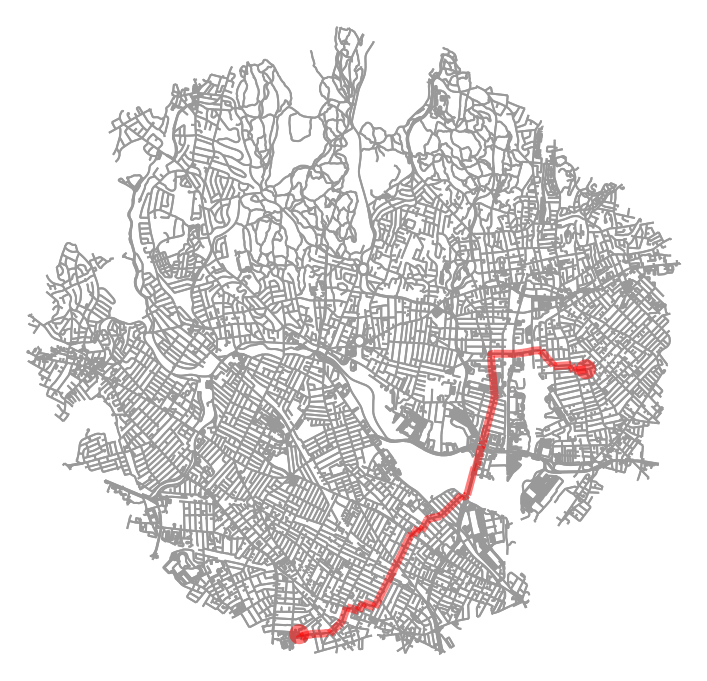

In [56]:
# find the route between these nodes then plot it
route = nx.shortest_path(neighbor, 3809869827, 65339393, weight='length')
fig, ax = ox.plot_graph_route(neighbor, route, node_size=0)

####     Checks to see if a neighborhood node is the city and creates a column based on data in the node geopandas dataframe

In [57]:
_ = gf.city_node(nodes_med,"medford",nodes_area)

In [58]:
nodes_area.head()

highway       osmid  ref          x          y  \
3809869824     NaN  3809869824  NaN -71.114121  42.379348   
65339393       NaN    65339393  NaN -71.062293  42.415550   
3809869827     NaN  3809869827  NaN -71.115105  42.379540   
66453510       NaN    66453510  NaN -71.122518  42.438382   
3809869832     NaN  3809869832  NaN -71.115190  42.379899   

                                         geometry  major       color  \
3809869824         POINT (-71.1141215 42.3793477)  minor  whitesmoke   
65339393           POINT (-71.0622932 42.4155504)  minor  whitesmoke   
3809869827  POINT (-71.11510509999999 42.3795404)  minor  whitesmoke   
66453510             POINT (-71.122518 42.438382)  minor  whitesmoke   
3809869832  POINT (-71.11519029999999 42.3798988)  minor  whitesmoke   

            major_inter  medford  
3809869824            0        0  
65339393              0        0  
3809869827            0        0  
66453510              0        1  
3809869832            0        0

# 4 Google Directions Import

#### Google perfered routes happen over the google api. The following chart shows the approximation between the intersection use and Pareto Principle. 80% of the traffic is concentrated in 20% of the intersections.

50853 references of 499 nodes 

Top 10 nodes in list

1 	 [(42.4191023, -71.11793759999999), 1369]
2 	 [(42.43623909999999, -71.1019761), 1205]
3 	 [(42.4175248, -71.1179305), 1050]
4 	 [(42.41664189999999, -71.110641), 1050]
5 	 [(42.4245735, -71.1062702), 1036]
6 	 [(42.4153957, -71.1105742), 1033]
7 	 [(42.4115429, -71.1217863), 1021]
8 	 [(42.4287603, -71.1025933), 1010]
9 	 [(42.4342774, -71.08368829999999), 979]
10 	 [(42.4058567, -71.0980563), 887]


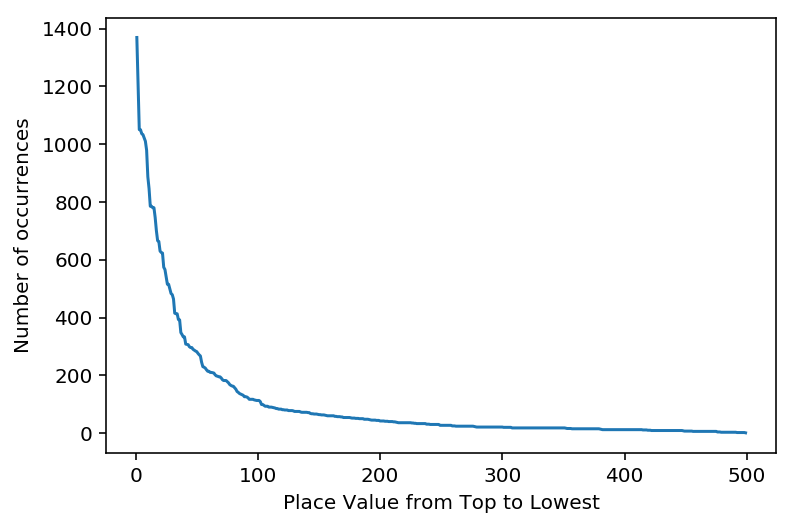

In [59]:
gmap, complete_node, node_occurances = gf.directionsToDataframe("10.Google_directions_api_all6k.csv")

# 4a. Google top 10 nodes

In [61]:
gmap.head()

osmid_start  lng_start  lat_start  start_zone  osmid_end    lng_end  \
0     66450694 -71.090072  42.436659           1   66449255 -71.092265   
1     66450694 -71.090072  42.436659           1   66449255 -71.092265   
2     66450694 -71.090072  42.436659           1   66449255 -71.092265   
3     66436104 -71.088950  42.439999           1   66445131 -71.090880   
4     66436104 -71.088950  42.439999           1   66445131 -71.090880   

     lat_end  end_zone   Time             Time_adj distance duration  \
0  42.411050         2   8:30  May 31 2019  8:30AM   2.8 mi   8 mins   
1  42.411050         2  15:30  May 31 2019  3:30PM   2.8 mi   8 mins   
2  42.411050         2  17:30  May 31 2019  5:30PM   2.8 mi   8 mins   
3  42.411045         2   8:30  May 31 2019  8:30AM   2.9 mi   9 mins   
4  42.411045         2  15:30  May 31 2019  3:30PM   2.9 mi   9 mins   

  duration_in_traffic                                        coordinates  \
0              9 mins  {0: {'lat': 42.4373659, 'lng': -71.08992169999...   
1              9 mins  {0: {'lat': 42.4373659, 'lng': -71.08992169999...   
2             10 mins  {0: {'lat': 42.4373659, 'lng': -71.08992169999...   
3             10 mins  {0: {'lat': 42.4406768, 'lng': -71.0907357}, 1...   
4             10 mins  {0: {'lat': 42.4406768, 'lng': -71.0907357}, 1...   

                                          directions  steps  \
0  {0: 'Head north on Palmer St toward Park Ave',...      6   
1  {0: 'Head north on Palmer St toward Park Ave',...      6   
2  {0: 'Head north on Palmer St toward Park Ave',...      6   
3  {0: 'Head west on E Border Cir toward E Border...      6   
4  {0: 'Head west on E Border Cir toward E Border...      6   

                                     node_directions  
0  [(42.4373659, -71.08992169999999), (42.4386632...  
1  [(42.4373659, -71.08992169999999), (42.4386632...  
2  [(42.4373659, -71.08992169999999), (42.4386632...  
3  [(42.4406768, -71.0907357), (42.4404727, -71.0...  
4  [(42.4406768, -71.0907357), (42.4404727, -71.0...

In [64]:
google_top = gf.traffic_node(nodes_area, node_occurances)
g_list = list(google_top[google_top.traffic_importance > 887].osmid.values)

In [65]:
google_top[google_top.traffic_importance > 887]

highway     osmid          ref          x          y  \
66455370  traffic_signals  66455370  MA 16/MA 38 -71.117942  42.419096   
66458425  traffic_signals  66458425          NaN -71.110596  42.416629   
66459547  traffic_signals  66459547          NaN -71.121782  42.411549   
66464026              NaN  66464026          NaN -71.117945  42.417517   
65358204              NaN  65358204          NaN -71.083640  42.434357   
66424429              NaN  66424429          NaN -71.110593  42.415511   
66426296              NaN  66426296          NaN -71.102557  42.428794   
66430240              NaN  66430240          NaN -71.101967  42.436268   
66444502  traffic_signals  66444502          NaN -71.106271  42.424573   

                                       geometry                    major  \
66455370           POINT (-71.117942 42.419096)  MA 16;MA 38 MA 38 MA 16   
66458425         POINT (-71.1105965 42.4166294)                    MA 38   
66459547           POINT (-71.121782 42.411549)                    minor   
66464026         POINT (-71.1179454 42.4175169)                    minor   
65358204         POINT (-71.0836398 42.4343575)                    minor   
66424429          POINT (-71.1105927 42.415511)                    MA 38   
66426296           POINT (-71.102557 42.428794)                    MA 28   
66430240         POINT (-71.1019671 42.4362676)                    MA 28   
66444502  POINT (-71.10627100000001 42.4245726)                    minor   

                color  major_inter  medford  traffic_importance  
66455370        black            6        1                1369  
66458425  yellowgreen            1        1                1050  
66459547   whitesmoke            0        1                1021  
66464026   whitesmoke            0        1                1050  
65358204   whitesmoke            0        0                 979  
66424429  yellowgreen            1        1                1033  
66426296         grey            1        1                1010  
66430240         grey            1        1                1205  
66444502   whitesmoke            0        1                1036

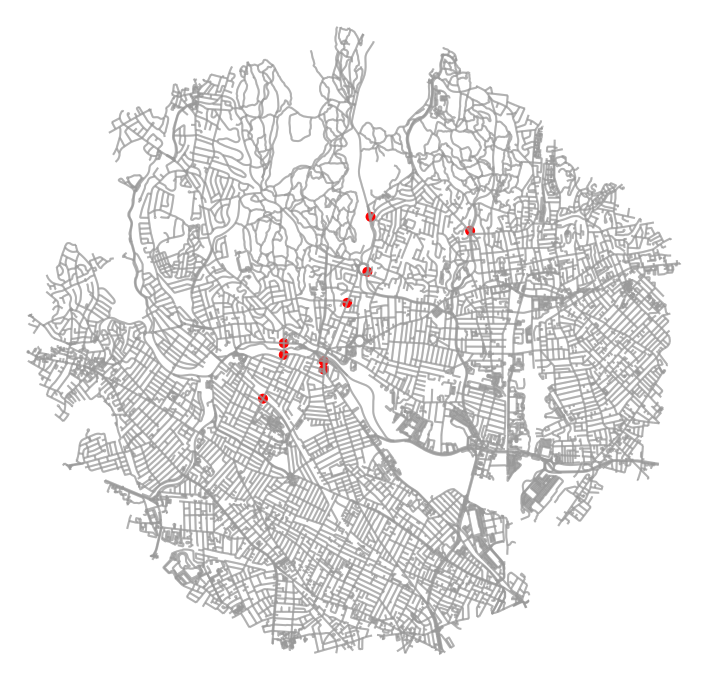

In [66]:
# Edge and Node projection
nodes_area, edges_area = ox.graph_to_gdfs(neighbor_projected,
                                        nodes=True,
                                        edges=True)

g_size = [25 if i in g_list else 0 for i in neighbor.nodes()]

ox.plot_graph(neighbor,
              node_size=g_size,
              node_color = "red", edge_alpha= .5);

# 5. Initial Monte Carlo Simulation

#### Rules:

1. Simulation
    1. All disasters originate in Medford with no spill over
    2. 5 patrol officers who maybe inside disaster radius
    3. 5 officers dispatched from station
    4. Police do not follow one way road rules
    5. 10 randomly selected node emergencies inside disaster radius
    6. Best route chosen for all officers
    7. Officers dispatched for on foot for unreachable emergencies (distance 10,000 listed)
    8. 10,000 simulations
    9. I-93 is taken out by the disaster
    10. Disaster radius randomly selected
2. Questions to answer
    1. Average police travel distance
    2. Most used nodes by police


In [68]:
import time
import pickle
from scipy.optimize import linear_sum_assignment


#Populate police station

"""
Medford Police:
100 Main St, Medford, MA 02155
42.415811 -71.110152
"""

police_node = gf.nodefinder(nodes_med,
                            lat = 42.415811,
                            lng = -71.110152)




def monte_simulator(p_e_samples, police_location, simulations, name = ""): 

    main_start = time.time()
    
    police_node = gf.nodefinder(nodes_med,
                            lat = police_location[0],
                            lng = police_location[1])
    
    police_station = [police_node] * p_e_samples
    
    p_e_samples *= 2 

    
    monte_simulation = {}
    #Iteration though simulation
    for sim in range(0,simulations):
        
        #Initialization
        start = time.time()
        print("Starting simulation: {} at time: {}".format(sim,round(start - main_start,2)))
        monte_dis = {}

        #Generates disaster and radius
        disaster_location = nodes_med.sample(1)
        
        monte_dis["dis_location"] = disaster_location
        
        monte_dis["dis_rad"] = np.random.uniform(low = .4, high = .9) * 4000
        

        monte_dis["disaster"] = gf.disaster_generator(nodes_med,
                                                      location_point = disaster_location[["y","x"]].values[0],
                                                      radius = monte_dis["dis_rad"],
                                                      plotter = 0)
        
        
        monte_dis["nodes_effected"] = len(monte_dis["disaster"].nodes())
        monte_dis["roads_effected"] = len(monte_dis["disaster"].edges())
        
        
        #Randomly destroys roads in disaster radius 
        monte_dis["remain_per"] = np.random.uniform(low = .35, high = 1)

        monte_dis["remaining"] = gf.road_kill(monte_dis["disaster"],
                                              nodes_area, #These come from the neighborhood
                                              edges_area,
                                              kill_percentage = monte_dis["remain_per"],
                                              plotter = 0)

        #Make dictionaries for emergencies and police
        e_list = np.random.choice(list(monte_dis["disaster"].nodes()),
                                  replace=False,
                                  size = p_e_samples)

        p_list = list(nodes_med.sample(int(p_e_samples / 2)).osmid.values)
        p_list.extend(police_station)

        monte_dis["emergency"] = {}
        monte_dis["patrol"] = {}

        for i in range(0,p_e_samples):
            monte_dis["patrol"]["officer_{}".format(i)] = p_list[i]
            monte_dis["emergency"]["emergency_{}".format(i)] = e_list[i]

        rows = list(monte_dis["patrol"].keys())
        columns = list(monte_dis["emergency"].keys())

        #Distance Matrix
        d_matrix = pd.DataFrame(columns = columns,
                                index = rows)

        for i in range(len(rows)):
            for j in range(len(columns)):
                try:
                    path = nx.shortest_path_length(monte_dis["remaining"], 
                                                       monte_dis["patrol"][rows[i]], 
                                                       monte_dis["emergency"][columns[j]], 
                                                       weight='length')
                except:
                    path = 10_000

                d_matrix.loc[rows[i], columns[j]] = path

        monte_dis["distance_matrix"] = d_matrix.astype(float)

        #Use Hungarian algorithm for linear sum assignment
        lsa = linear_sum_assignment(monte_dis["distance_matrix"].to_numpy())
        adj_matrix = np.matrix(np.zeros((10, 10)))

        #optimized distances
        od_list = []
        for i in range(len(lsa[0])):
            od = monte_dis["distance_matrix"].iloc[lsa[0][i],lsa[1][i]]
            adj_matrix[lsa[0][i],lsa[1][i]] = od
            od_list.append(od)

        dispatch = {"officer_{}".format(lsa[0][i]):["emergency_{}".format(lsa[1][i]), 
                                                    od_list[i]] for i in range(len(lsa[0]))}

        monte_dis["ad_matrix"] = adj_matrix
        monte_dis["dispatch"] = dispatch
        monte_dis["dispatch_distance"] = sum(od_list)


        monte_simulation[sim] = monte_dis

        if sim % 200 == 0:
            print("pickle dump")
            pickle.dump(monte_simulation, open( "monte_simulation_{}_{}.p".format(name,sim), "wb" ))

        end = time.time()
        print("Ending simulation: {}. Total {} seconds for run\n".format(sim,round(end - start,2)))
        
    return monte_simulation

#### Demo of five simulated disasters

In [69]:
monte_simulation = monte_simulator(5,[42.415811,-71.110152], 5, "demo")

Starting simulation: 0 at time: 0.05
667116 roads remain of 667836 total roads
pickle dump
Ending simulation: 0. Total 21.53 seconds for run

Starting simulation: 1 at time: 21.57
646416 roads remain of 667836 total roads
Ending simulation: 1. Total 52.21 seconds for run

Starting simulation: 2 at time: 73.78
667224 roads remain of 667836 total roads
Ending simulation: 2. Total 20.94 seconds for run

Starting simulation: 3 at time: 94.72
646164 roads remain of 667836 total roads
Ending simulation: 3. Total 35.16 seconds for run

Starting simulation: 4 at time: 129.88
664218 roads remain of 667836 total roads
Ending simulation: 4. Total 29.49 seconds for run



#### Simulations inside data dictionary

In [70]:
monte_simulation.keys()

dict_keys([0, 1, 2, 3, 4])

#### Terms inside of each simulation

In [79]:
monte_simulation[0].keys()

dict_keys(['dis_location', 'dis_rad', 'disaster', 'nodes_effected', 'roads_effected', 'remain_per', 'remaining', 'emergency', 'patrol', 'distance_matrix', 'ad_matrix', 'dispatch', 'dispatch_distance'])

#### Two Sample dispatches with corresponding distance in meters

In [80]:
monte_simulation[0]['dispatch']

{'officer_0': ['emergency_5', 3165.7219999999998],
 'officer_1': ['emergency_0', 4553.591],
 'officer_2': ['emergency_6', 5421.6460000000025],
 'officer_3': ['emergency_2', 6558.164000000001],
 'officer_4': ['emergency_3', 5265.956999999999],
 'officer_5': ['emergency_9', 2448.740000000001],
 'officer_6': ['emergency_8', 3775.5390000000007],
 'officer_7': ['emergency_7', 3491.234000000001],
 'officer_8': ['emergency_4', 2368.111000000001],
 'officer_9': ['emergency_1', 2863.6080000000006]}

In [82]:
monte_simulation[2]['dispatch']

{'officer_0': ['emergency_3', 2418.3430000000008],
 'officer_1': ['emergency_4', 1909.5639999999999],
 'officer_2': ['emergency_9', 10000.0],
 'officer_3': ['emergency_6', 2711.428999999999],
 'officer_4': ['emergency_0', 580.3219999999999],
 'officer_5': ['emergency_8', 3044.8880000000004],
 'officer_6': ['emergency_7', 2505.99],
 'officer_7': ['emergency_5', 3718.0879999999997],
 'officer_8': ['emergency_2', 2008.5919999999999],
 'officer_9': ['emergency_1', 3077.2379999999994]}

In [86]:
monte_simulation[2]["ad_matrix"]

matrix([[    0.   ,     0.   ,     0.   ,  2418.343,     0.   ,
             0.   ,     0.   ,     0.   ,     0.   ,     0.   ],
        [    0.   ,     0.   ,     0.   ,     0.   ,  1909.564,
             0.   ,     0.   ,     0.   ,     0.   ,     0.   ],
        [    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
             0.   ,     0.   ,     0.   ,     0.   , 10000.   ],
        [    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
             0.   ,  2711.429,     0.   ,     0.   ,     0.   ],
        [  580.322,     0.   ,     0.   ,     0.   ,     0.   ,
             0.   ,     0.   ,     0.   ,     0.   ,     0.   ],
        [    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
             0.   ,     0.   ,     0.   ,  3044.888,     0.   ],
        [    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
             0.   ,     0.   ,  2505.99 ,     0.   ,     0.   ],
        [    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
          3718.088,     0.   ,   

#### Data frame generation

In [71]:
size_list = range(len(monte_simulation))

In [73]:
df = pd.concat([monte_simulation[i]["dis_location"].copy() for i in size_list]).reset_index(drop=True)

In [76]:
extra_data = ['dis_rad', 'nodes_effected', 'roads_effected', 'remain_per', 'dispatch_distance']

In [77]:
for i in range(len(monte_simulation)):
    for j in extra_data:
        df.loc[i, j] = monte_simulation[i][j]

In [78]:
df.columns

Index(['highway', 'osmid', 'ref', 'x', 'y', 'geometry', 'major', 'color',
       'major_inter', 'dis_rad', 'nodes_effected', 'roads_effected',
       'remain_per', 'dispatch_distance'],
      dtype='object')

In [84]:
X = df[['osmid','x', 'y','dis_rad', 'nodes_effected', 'roads_effected',
       'remain_per', 'dispatch_distance']]

In [85]:
X.head()

osmid          x          y      dis_rad  nodes_effected  \
0    66457384 -71.141971  42.422531  1705.878532           395.0   
1  1492438714 -71.084046  42.405243  3372.581750          2166.0   
2  1479863481 -71.076628  42.411783  1904.437873           288.0   
3    66474274 -71.136638  42.429198  3004.994641          1097.0   
4    66452598 -71.102182  42.430619  3265.576548          1299.0   

   roads_effected  remain_per  dispatch_distance  
0          1044.0    0.447029          39912.312  
1          4908.0    0.891804          34964.692  
2           663.0    0.523666          31974.454  
3          2873.0    0.903811          43564.304  
4          3154.0    0.448429          17719.268